# Simple SNN Network for NMNIST Dataset Classification

The goal of this script is to train and test a simple SNN network to then extract the weights and map them to a simple SNN network in C++.

### 1. Imports

In [112]:
# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.utils.data import random_split
import torchvision

# Additional Imports
import snntorch as snn
import matplotlib.pyplot as plt
import numpy as np
import time
import os

# Dataset
import tonic
import tonic.transforms as transforms
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset

# Network
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils

# Set the seed for reproducibility of results
torch.manual_seed(0)

### 2. NMNIST Dataset Preparation 

In [113]:
dataset = tonic.datasets.NMNIST(save_to='./data', train=True)
events, target = dataset[0]
print(events)

[( 8, 16,   4231, 1) ( 9, 16,   6817, 1) (19, 16,   8789, 0) ...
 (15, 18, 303482, 1) (18,  3, 305393, 1) (21, 25, 306195, 1)]


/tmp/ipykernel_19453/305858719.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  tonic.utils.plot_event_grid(events)


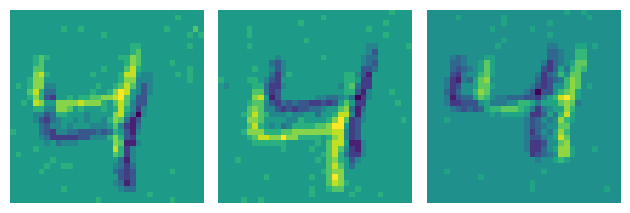

In [114]:
tonic.utils.plot_event_grid(events)

In [115]:
sensor_size = tonic.datasets.NMNIST.sensor_size

# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000), 
                                      transforms.ToFrame(sensor_size=sensor_size, time_window=10000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=frame_transform, train=False)

In [116]:
def load_sample_simple():
    for i in range(100):
        events, target = trainset[i]

In [117]:
%timeit -o load_sample_simple()

870 ms ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 870 ms ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [118]:
cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_dataloader = DataLoader(cached_trainset)

batch_size = 64
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

In [119]:
def load_sample_batched():
    events, target = next(iter(cached_dataloader))

In [120]:
%timeit -o -r 10 load_sample_batched()

6.25 ms ± 833 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


<TimeitResult : 6.25 ms ± 833 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)>

In [121]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as torchvision_transforms
import tonic
import tonic.transforms as transforms

# Define sensor size for NMNIST dataset
sensor_size = tonic.datasets.NMNIST.sensor_size

# Define transformations
# Note: The use of torch.from_numpy is removed as Tonic's transforms handle conversion.
transform = tonic.transforms.Compose([
    transforms.Denoise(filter_time=10000),
    transforms.ToFrame(sensor_size=sensor_size, time_window=10000),
    # torchvision.transforms.RandomRotation is not directly applicable to event data.
    # If rotation is needed, it should be done on the frames after conversion by ToFrame.
])

# Load NMNIST datasets without caching
trainset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=transform, train=False)

# Split trainset into training and validation datasets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Create DataLoaders for training, validation, and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=tonic.collation.PadTensors(batch_first=False))
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))
test_loader = DataLoader(testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

# Fetch a single batch from the train_loader to inspect the shape
data, targets = next(iter(train_loader))
print(f"Data shape: {data.shape}")  # Example output: torch.Size([batch_size, timesteps, channels, height, width])
print(f"Targets shape: {targets.shape}")  # Example output: torch.Size([batch_size])


Data shape: torch.Size([31, 128, 2, 34, 34])
Targets shape: torch.Size([128])


In [122]:
# Fetch a single batch from the train_loader
data, targets = next(iter(train_loader))

# Assuming your data is in the format [timesteps, batch_size, channels, height, width]
# Check the shape of the data tensor
print(f"Data shape: {data.shape}")

# Check the shape of the targets tensor
print(f"Targets shape: {targets.shape}")

Data shape: torch.Size([31, 128, 2, 34, 34])
Targets shape: torch.Size([128])


### 3. Model Definition

#### 3.1 Parameters

In [123]:
config = {
    # SNN
    "threshold1": 2.5,
    "threshold2": 8.0,
    "threshold3": 4.0,
    "threshold4": 2.0,
    "beta": 0.5,
    "num_steps": 10,
    
    # SNN Dense Shape
    "dense1_input": 2312,
    "num_classes": 10,
    

    # Network
    "batch_norm": True,
    "dropout": 0.3,

    # Hyper Params
    "lr": 0.007,

    # Early Stopping
    "min_delta": 1e-6,
    "patience_es": 20,

    # Training
    "epochs": 2
}

#### 3.2 Model

In [124]:
class SNN(nn.Module):
  def __init__(self, config):
    super(SNN, self).__init__()

    # Initialize configuration parameters
      # LIF
    self.thresh1 = config["threshold1"]
    self.thresh2 = config["threshold2"]
    self.thresh3 = config["threshold3"]
    self.thresh4 = config["threshold4"]
    self.beta = config["beta"]
    self.num_steps = config["num_steps"]

      # Hyper Params for Layers
    self.batch_norm = config["batch_norm"]
    self.dropout_percent = config["dropout"]

      # Dense Shape
    self.dense1_input = config["dense1_input"]
    self.num_classes = config["num_classes"]

      # Network Layers
    self.fc1 = nn.Linear(self.dense1_input, self.dense1_input//4)
    self.lif1 = snn.Leaky(beta=self.beta, threshold=self.thresh1)
    
    
    self.fc2 = nn.Linear(self.dense1_input//4, self.dense1_input//8)
    self.lif2 = snn.Leaky(beta=self.beta, threshold=self.thresh2)
    
    self.fc3 = nn.Linear(self.dense1_input//8, self.num_classes)
    self.lif3 = snn.Leaky(beta=self.beta, threshold=self.thresh3)
    
    self.flatten = nn.Flatten()
    self.fc4 = nn.Linear(self.dense1_input//8, self.num_classes)
    self.lif4 = snn.Leaky(beta=self.beta, threshold=self.thresh4)
    self.dropout = nn.Dropout(self.dropout_percent)
    
    # Extra (not used)
    self.batch_norm_1 = nn.BatchNorm2d(num_features=16)
    self.batch_norm_2 = nn.BatchNorm2d(num_features=32)
    
    
    # Forward Pass
  def forward(self, inpt):
    mem1 = self.lif1.init_leaky()
    mem2 = self.lif2.init_leaky()
    mem3 = self.lif3.init_leaky()
    #mem4 = self.lif4.init_leaky()

    spike3_rec = []
    mem3_rec = []
    
    #print(inpt.shape)

    for step in range(inpt.shape[0]):
      #print(inpt[step].shape)
      
      current_input = inpt[step]
      current_input = self.flatten(current_input)
      
      current1 = self.fc1(current_input)
      spike1, mem1 = self.lif1(current1, mem1)

      current2 = self.fc2(spike1)
      spike2, mem2 = self.lif2(current2, mem2)

      current3 = self.fc3(spike2)
      spike3, mem3 = self.lif3(current3, mem3)
      
      #current4 = self.fc4(spike3)
      #spike4, mem4 = self.lif4(current4, mem4)

      spike3_rec.append(spike3)
      mem3_rec.append(mem3)

    return torch.stack(spike3_rec, dim=0), torch.stack(mem3_rec, dim=0)

### 4. Training


#### 4.1 Early Stopping

In [125]:
class EarlyStopping:
    def __init__(self, patience=config["patience_es"], min_delta=config["min_delta"]):
        # Early stops the training if validation loss doesn't improve after a given patience.
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.min_delta:
            self.counter += 1
            print(f"Earlystop {self.counter}/{self.patience}\n")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

#### 4.2 Training Set-Up

In [126]:
# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SNN(config).to(device)

# Optimizer and Loss Function
optimizer = Adam(model.parameters(), lr=config["lr"])
criterion = nn.CrossEntropyLoss()

# Early Stopping
early_stopping = EarlyStopping(patience=config["patience_es"], min_delta=config["min_delta"])

#### 4.3 Training Function

In [127]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        #print(data.shape)

        optimizer.zero_grad()
        spike_out, _ = model(data)
        output = spike_out.sum(dim=0)
        loss = criterion(output, targets)
        running_loss += loss.item()

        _, predicted_train = torch.max(output.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted_train == targets).sum().item()
        
        print(f"Train Loss: {loss.item():.2f}")
        
        acc = SF.accuracy_rate(spike_out, targets) 
        print(f"Accuracy: {acc * 100:.2f}%\n")

        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    return train_loss, train_accuracy

#### 4.4 Validation Function

In [128]:
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            spike_out, _ = model(data)
            output = spike_out.sum(dim=0)
            loss = criterion(output, targets)
            val_loss += loss.item()

            _, predicted_val = torch.max(output.data, 1)
            total_val += targets.size(0)
            correct_val += (predicted_val == targets).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    return val_loss, val_accuracy

#### 4.5 Training Loop

In [129]:
from tqdm import tqdm

train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
best_val_accuracy = 0
model_path = "best_SNN_model.pth"

for epoch in tqdm(range(config["epochs"]), desc="Epochs"):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    tqdm.write(f"Epoch: {epoch + 1}, Training Loss: {train_loss:.5f}, Training Accuracy: {train_accuracy:.2f}%, "
               f"Validation Loss: {val_loss:.5f}, Validation Accuracy: {val_accuracy:.2f}%\n")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), model_path)
        tqdm.write(f"Saved model with improved validation accuracy: {val_accuracy:.2f}% \n")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        tqdm.write("\nEarly stopping triggered")
        break

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 2.30
Accuracy: 10.94%

Train Loss: 2.30
Accuracy: 6.25%

Train Loss: 2.30
Accuracy: 12.50%

Train Loss: 2.30
Accuracy: 15.62%

Train Loss: 2.30
Accuracy: 4.69%

Train Loss: 2.30
Accuracy: 7.81%

Train Loss: 2.30
Accuracy: 8.59%

Train Loss: 2.30
Accuracy: 10.16%

Train Loss: 2.70
Accuracy: 6.25%

Train Loss: 2.30
Accuracy: 14.84%

Train Loss: 2.30
Accuracy: 8.59%

Train Loss: 2.31
Accuracy: 6.25%

Train Loss: 2.30
Accuracy: 7.03%

Train Loss: 2.31
Accuracy: 3.12%

Train Loss: 2.31
Accuracy: 7.03%

Train Loss: 2.24
Accuracy: 9.38%

Train Loss: 2.24
Accuracy: 7.03%

Train Loss: 2.13
Accuracy: 16.41%

Train Loss: 2.15
Accuracy: 16.41%

Train Loss: 2.13
Accuracy: 16.41%

Train Loss: 2.12
Accuracy: 24.22%

Train Loss: 2.01
Accuracy: 26.56%

Train Loss: 2.11
Accuracy: 27.34%

Train Loss: 1.70
Accuracy: 49.22%

Train Loss: 1.87
Accuracy: 34.38%

Train Loss: 1.53
Accuracy: 52.34%

Train Loss: 1.78
Accuracy: 37.50%

Train Loss: 1.69
Accuracy: 43.75%

Train Loss: 1.59
Accuracy: 48.44

Epochs:  50%|█████     | 1/2 [14:00<14:00, 840.33s/it]

Epoch: 1, Training Loss: 0.45662, Training Accuracy: 84.59%, Validation Loss: 0.18672, Validation Accuracy: 94.20%

Saved model with improved validation accuracy: 94.20% 

Train Loss: 0.11
Accuracy: 96.88%

Train Loss: 0.21
Accuracy: 94.53%

Train Loss: 0.21
Accuracy: 90.62%

Train Loss: 0.10
Accuracy: 96.09%

Train Loss: 0.13
Accuracy: 96.88%

Train Loss: 0.23
Accuracy: 92.19%

Train Loss: 0.05
Accuracy: 100.00%

Train Loss: 0.08
Accuracy: 97.66%

Train Loss: 0.19
Accuracy: 95.31%

Train Loss: 0.18
Accuracy: 95.31%

Train Loss: 0.21
Accuracy: 95.31%

Train Loss: 0.22
Accuracy: 94.53%

Train Loss: 0.14
Accuracy: 96.88%

Train Loss: 0.17
Accuracy: 94.53%

Train Loss: 0.12
Accuracy: 94.53%

Train Loss: 0.12
Accuracy: 95.31%

Train Loss: 0.15
Accuracy: 93.75%

Train Loss: 0.07
Accuracy: 98.44%

Train Loss: 0.33
Accuracy: 92.97%

Train Loss: 0.18
Accuracy: 96.09%

Train Loss: 0.11
Accuracy: 96.88%

Train Loss: 0.15
Accuracy: 95.31%

Train Loss: 0.12
Accuracy: 96.88%

Train Loss: 0.10
Accur

Epochs: 100%|██████████| 2/2 [28:19<00:00, 849.50s/it]

Epoch: 2, Training Loss: 0.14288, Training Accuracy: 95.62%, Validation Loss: 0.12797, Validation Accuracy: 95.93%

Saved model with improved validation accuracy: 95.93% 



### 5. Visualization

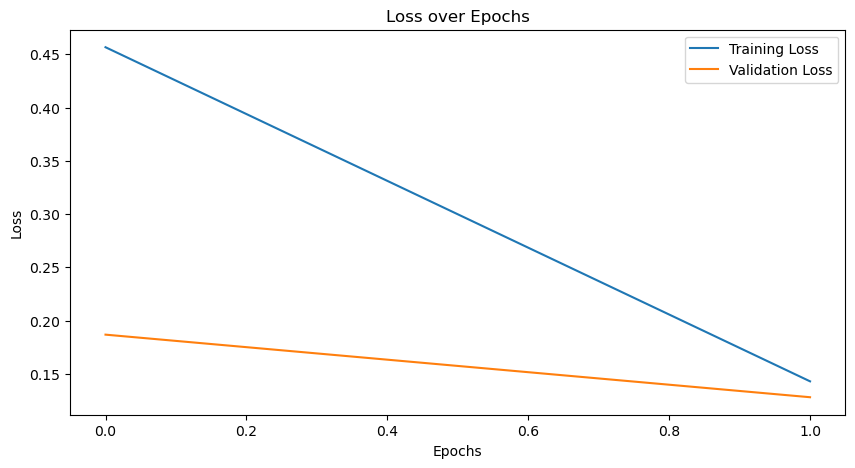

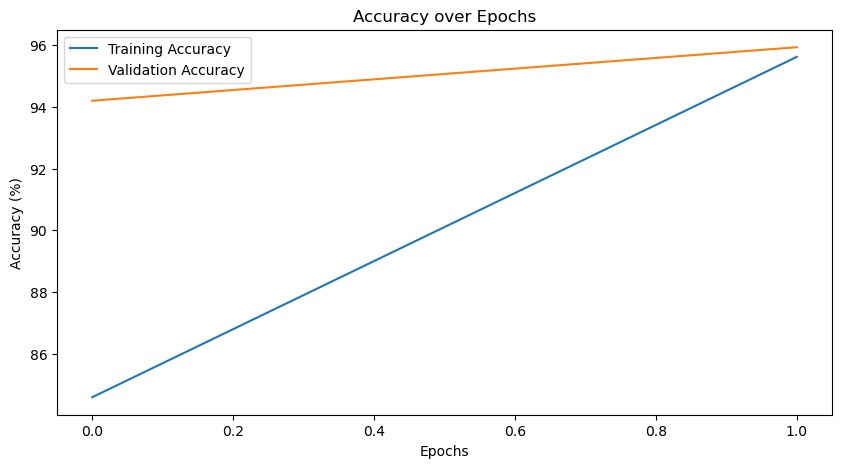

In [130]:
# Plotting training, validation, and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training, validation, and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### 6. Testing

In [131]:
def test(model, test_loader, criterion, device, model_path="best_SNN_model.pth"):

    # Initialize variables for test loss and accuracy
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    # Restore best BSNN Model
    if os.path.isfile(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"Loaded saved model from {model_path}\n")

    # Switch model to evaluation mode
    model.eval()

    # Iterate over the test data
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            outputs, _ = model(data)  # Modify according to your model's output
            outputs = outputs.mean(dim=0)

            # Calculate loss
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()

    # Calculate average loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_test / total_test

    return test_loss, test_accuracy


In [132]:
test_loss, test_accuracy = test(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Loaded saved model from best_SNN_model.pth

Test Loss: 2.0144, Test Accuracy: 96.45%
